In [7]:
import os
import pickle
from collections import defaultdict, OrderedDict
import numpy as np
import matplotlib.pyplot as mp
import tikzplotlib
import math

In [3]:
basedir = "Experiments/CDPExperiment_Hi_Txf/AssetsLo/logs"
experiment_basedir = "Experiments/CDPExperiment_Lo_Txf/AssetsLo/analysis"

In [4]:
def getvars(path):
    base_path = experiment.split('{')[1][:-1]
    
    s = base_path.split(',')
    
    var_dict = {}
    
    for i in s:
        a,b = i.split(':')
        var_dict[a] = float(b)
        
    return var_dict

In [9]:
inc = 0
dec = 0
concave = 0
convex = 0

mean_usd = defaultdict(dict)
mean_dai = defaultdict(dict)
stddev_usd = defaultdict(dict)
stddev_dai = defaultdict(dict)

def get_type(a,b,c, path):
    global inc, dec, concave, convex, mean_dai, mean_usd, stddev_usd, stddev_dai
    var_dict = getvars(path)
    key = 'other'
    if a < b < c:
        inc += 1
        key = 'increasing'
    elif a > b > c:
        dec += 1
        key = 'decreasing'
    elif a < b > c:
        concave += 1
        key = 'concave'
    elif a > b < c :
        convex += 1
        key = 'convex'
        
    try:
        mean_dai[var_dict['mean_dai']][key] += 1
        mean_usd[var_dict['mean_usd']][key] += 1
        stddev_usd[var_dict['stddev_usd']][key] += 1
        stddev_dai[var_dict['stddev_dai']][key] += 1
    except KeyError:
        mean_dai[var_dict['mean_dai']][key] = 1
        mean_usd[var_dict['mean_usd']][key] = 1
        stddev_usd[var_dict['stddev_usd']][key] = 1
        stddev_dai[var_dict['stddev_dai']][key] = 1    

In [10]:
for experiment in os.listdir(basedir):
    infile = open(basedir + "/" + experiment + "/sim-summary.pickle", 'rb')
    a,b,c,d, _, _ = pickle.load(infile)
    get_type(d[0], d[6],d[-1], experiment)
    infile.close()

In [11]:
print(inc, dec, convex, concave)

0 0 0 0


In [127]:
def print_dict(var_dict, name):
    print(name)
    for i in sorted(var_dict):
        temp = []
        for k in sorted(var_dict[i]):
            temp.append(k + ":" + str(var_dict[i][k]) + " ")
        
        print(i , ",".join(temp))
    print()    

def print_dicts():
    print_dict(mean_usd, "Mean USD")
    print_dict(stddev_usd, "Stddev USD")
    print_dict(mean_dai, "Mean DAI")
    print_dict(stddev_dai, "Stddev DAI")

In [128]:
print_dicts()

Mean USD
100.0 concave:4 ,convex:55 ,decreasing:7 ,increasing:44 ,other:3 
325.0 concave:2 ,convex:65 ,decreasing:29 ,increasing:24 ,other:1 
550.0 concave:3 ,convex:58 ,decreasing:38 ,increasing:21 ,other:1 
775.0 concave:5 ,convex:49 ,decreasing:45 ,increasing:17 ,other:2 
1000.0 concave:8 ,convex:44 ,decreasing:48 ,increasing:19 

Stddev USD
30.0 concave:4 ,convex:63 ,decreasing:32 ,increasing:22 ,other:1 
64.1675 concave:2 ,convex:56 ,decreasing:31 ,increasing:26 
98.335 concave:6 ,convex:56 ,decreasing:31 ,increasing:27 ,other:1 
132.5025 concave:4 ,convex:58 ,decreasing:39 ,increasing:20 ,other:2 
166.67 concave:8 ,convex:42 ,decreasing:38 ,increasing:31 ,other:2 

Mean DAI
100.0 concave:11 ,convex:10 ,decreasing:72 ,increasing:19 ,other:2 
325.0 concave:9 ,convex:39 ,decreasing:30 ,increasing:43 ,other:1 
550.0 convex:69 ,decreasing:22 ,increasing:31 ,other:1 
775.0 concave:1 ,convex:81 ,decreasing:21 ,increasing:20 
1000.0 concave:3 ,convex:74 ,decreasing:24 ,increasing:14 ,oth

### Asset Curve Variance Analysis (Not for multiple runs)

In [8]:
def process_plots(risk_basedir, plot_var):

    for basedir in sorted(os.listdir(risk_basedir)):
        risk_string = basedir.split('_')[-1]
        
        if "perc" in basedir:
            continue

        investor_id = int(basedir[14])

        plot_title  = ""

        log = False
        
        if risk_string == 'low':
            print("Investor" , investor_id, " More Risky")
            plot_title = "Investor " + str(investor_id) +  ":More Risky"
        else:
            print("Investor" , investor_id, " Less Risky")
            plot_title = "Investor " + str(investor_id) +  ":Less Risky"

        result_matrix = defaultdict(list)

        for asset_curve_plot_name in os.listdir(os.path.join(risk_basedir, basedir)):
            infile = open(os.path.join(experiment_basedir, asset_curve_plot_name[:-5], "sim-summary.pickle"), 'rb')
                        
            # Some data wrangling
            cdp_axis, txf_axis, run_axis, dai_price_history_axis, asset_history_axis, risk_params = pickle.load(infile)

            usd = defaultdict(list)
            eth = defaultdict(list)
            dai = defaultdict(list)
            ceth = defaultdict(list)

            cdp_rates = set()

            for cdp, txf, daip, a_h in zip(cdp_axis, txf_axis, dai_price_history_axis, asset_history_axis):
                for i in range(num_investors):
                        if i == investor_id:
                            result_matrix[(cdp, txf, i, risk_string, "usd")].append((a_h[-1][i][0] - a_h[0][i][0], asset_curve_plot_name, daip))
                            result_matrix[(cdp, txf, i, risk_string, "eth")].append((a_h[-1][i][1] - a_h[0][i][1], asset_curve_plot_name, daip))
                            result_matrix[(cdp, txf, i, risk_string, "dai")].append((a_h[-1][i][2] - a_h[0][i][2], asset_curve_plot_name, daip))
                            result_matrix[(cdp, txf, i, risk_string, "ceth")].append((a_h[-1][i][3] - a_h[0][i][3], asset_curve_plot_name, daip))

            infile.close()

        asset_filters = ["dai", "eth", "ceth"]
        
                
        plot_vars = set()

        for asset_filter in asset_filters:
            os.makedirs(os.path.join(plot_dir, asset_filter), exist_ok=True)
            os.makedirs(os.path.join(plot_dir, "dai_price"), exist_ok=True)

            # Plot variables for Y
            asset_change_mean_plot = []
            asset_change_stddev_plot = []

            maxi_plot = []
            mini_plot = []

            dai_price_mean_plot = []
            dai_price_stddev_plot = []

            #print("DAI Change Analysis")
            for dict_key in result_matrix:
                
                should_add = False
                
                if plot_var == "Tx Fee" and dict_key[0] == 0.06:
                    should_add = True
                elif plot_var == "CDP Rate" and dict_key[1] == 0.01:
                    should_add = True
                
                if should_add:
                    value_projection = [i[0] for i in result_matrix[dict_key]]
                    experiment_projection = [i[1] for i in result_matrix[dict_key]]
                    daip_projection = [i[2] for i in result_matrix[dict_key]]

                    if plot_var == "Tx Fee":
                        plot_vars.add(dict_key[1])
                    else:
                        plot_vars.add(dict_key[0])

                    if dict_key[4] == asset_filter:
                        asset_mean = round(np.mean(value_projection), 4)
                        asset_stddev = round(np.std(value_projection), 4)

                        asset_change_mean_plot.append(asset_mean)
                        asset_change_stddev_plot.append(asset_stddev)

                        mean_dai_price = round(np.mean(daip_projection), 4)
                        stddev_dai_price = round(np.std(daip_projection), 4)

                        dai_price_mean_plot.append(mean_dai_price)
                        dai_price_stddev_plot.append(stddev_dai_price)

                        if log:
                            print("CDP Rate:", dict_key[0], ", Tx Fee:", dict_key[1])
                            print("Mean Change:", asset_mean , ", Stddev Change:", asset_stddev)
                            print("Mean DAI Price:", mean_dai_price, ", Stddev DAI Price:", stddev_dai_price)

                        positive = np.count_nonzero([i >= 0 for i in value_projection])
                        negative = np.count_nonzero([i < 0 for i in value_projection])

                        if log:
                            print("Positive:", positive, ", Negative:", negative)

                        # Print Min and Max
                        min_idx = value_projection.index(min(value_projection))
                        max_idx = value_projection.index(max(value_projection))

                        maxi_plot.append(value_projection[max_idx])
                        mini_plot.append(value_projection[min_idx])

                        if log:
                            print("Minimum Experiment:" , value_projection[min_idx], ", risk_bitmask:", experiment_projection[min_idx][-16:-6])
                            print("Maximum Experiment:", value_projection[max_idx], ", risk_bitmask:", experiment_projection[max_idx][-16:-6])

                        if log:
                            print()

            # Plot Mean, Min, Max, Stddev DAI Change
            plot_var_list = sorted(list(plot_vars))
            
            print(plot_var_list, asset_change_mean_plot)

            mp.errorbar(plot_var_list, asset_change_mean_plot, yerr = asset_change_stddev_plot, marker='o')
            mp.plot(plot_var_list, maxi_plot, marker = 'o')
            mp.plot(plot_var_list, mini_plot, marker = 'o')
            mp.title(plot_title + " " + " | Mean " + asset_filter.upper() + " Change v/s " + plot_var)
            mp.xlabel(plot_var)
            mp.ylabel(asset_filter.upper() + " Change")

            plot_name = plot_dir + "/" + asset_filter + "/" + plot_title + "-Mean " + asset_filter.upper() + "-Change-" + plot_var 

            mp.savefig(plot_name + ".jpg")
            tikzplotlib.save(plot_name + ".tex")
            mp.clf()

            # Plot Mean, Stddev DAI Price
            mp.errorbar(plot_var_list, dai_price_mean_plot, yerr = dai_price_stddev_plot, marker='o')
            mp.xlabel(plot_var)
            mp.ylabel("DAI Price")
            mp.title(plot_title + " " + " | Mean DAI Price")

            plot_name = plot_dir + "/dai_price/" + plot_title + "-Mean DAI Price"
            mp.savefig(plot_name + ".jpg")
            tikzplotlib.save(plot_name + ".tex")
            mp.clf()


            if log:
                print()

In [23]:
for i in os.listdir("Experiments/SampleExp2/logs"):
    infile = open("Experiments/SampleExp2/logs/" + i + "/sim-summary.pickle", 'rb')
    
    try:
        cdp_axis, txf_axis, run_axis, dai_price_history_axis, asset_history_axis, risk_params = pickle.load(infile)
    except:
        print(i)

In [4]:
plot_main_dir = "NewPlots"
os.makedirs(plot_main_dir, exist_ok=True)

In [9]:
exp_names = ["CDPExperiment_Hi_Txf/AssetsHi", "CDPExperiment_Lo_Txf/AssetsHi", "CDP_HiExp", "CDP_MidExp", "CDP_0.06", "TXF_0.01"]
exp_plot_dir_names = ["{txf:0.14,cdp:vary}", "{txf:0.01,cdp:vary}", "{txf:vary,cdp:0.1}", "{txf:vary,cdp:0.06}","cdp_fix_0.06", "txf_fix_0.01"]
plot_vars = ["CDP Rate", "CDP Rate", "Tx Fee", "Tx Fee", "Tx Fee", "CDP Rate"]


exp_selectors = [5]

for exp_selector in exp_selectors:
    exp_name = exp_names[exp_selector]

    risk_basedir = "Experiments/" + exp_name + "/analysis/filter:risk"
    experiment_basedir = "Experiments/" + exp_name + "/logs"

    os.listdir(risk_basedir)

    num_investors = 10

    plot_dir = os.path.join(plot_main_dir, exp_plot_dir_names[exp_selector])
    os.makedirs(plot_dir, exist_ok=True)
    
    process_plots(risk_basedir, plot_vars[exp_selector])

Investor 0  Less Risky
[0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09] [-73.8882, -74.8798, -75.7897, -76.7868, -80.0619, -81.2537, -78.5916, -76.1104, -74.5073]
[0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09] [0.0, 0.0, 0.0, 0.0, 0.0, 0.0005, 0.047, 0.0944, 0.1283]
[0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09] [0.2909, 0.2773, 0.2636, 0.2496, 0.2361, 0.2203, 0.1393, 0.0573, 0.0]
Investor 0  More Risky
[0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09] [-1.7374, -1.1059, -0.4843, 0.8953, 3.3831, 2.3043, 0.8845, -0.4199, -1.0969]
[0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09] [0.0, 0.0, 0.0, 0.0325, 0.1836, 0.2219, 0.2215, 0.2209, 0.2203]
[0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09] [0.5093, 0.4616, 0.4141, 0.3218, 0.0656, 0.0, 0.0, 0.0, 0.0]
Investor 1  Less Risky
[0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09] [-17.4045, -18.4002, -19.3749, -20.4426, -23.6796, -24.6253, -22.4406, -20.418, -19.8382]
[0.01, 0.02, 0.03, 0.04, 0.05, 0.06

<Figure size 432x288 with 0 Axes>

## Market Size Plots

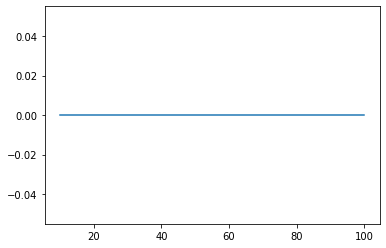

In [11]:
basedir = "Experiments/MDay/logs"



pos = {10:0, 25:1, 50:2, 75:3, 100:4}

data_y = [0 for i in range(5)]
data_x = [10, 25, 50, 75, 100]

for logdir in os.listdir(basedir):
    sim_plot_dir = os.path.join(basedir, logdir, "sim-summary.pickle")
    
    infile = open(sim_plot_dir, 'rb')
    cdp_axis, txf_axis, run_axis, dai_price_history_axis, asset_history_axis, risk_params = pickle.load(infile)
    
    cdp_rate = 0.06
    txfee = 0.02
    
    for cdp, txf, daip, a_h in zip(cdp_axis, txf_axis, dai_price_history_axis, asset_history_axis):
            if cdp == cdp_rate and txf == txfee:
                print(daip)
                data_y[pos[int(logdir.split('n:')[-1][:-1])]] = daip
            
            infile.close()

mp.plot(data_x, data_y)
    

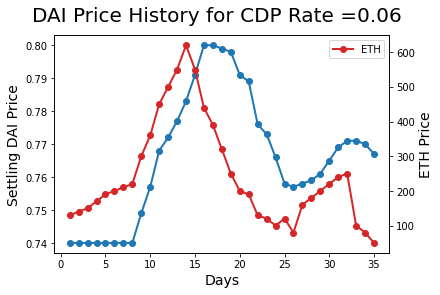

In [12]:
eth_price = [130,140,150,170,190,200,210,220,300,360,450,500,550,620,550,440,390,320,250,200,190,130,120,100,120,80,160,180,200,220,240,250,100,80,50]


experiment_dir = "Experiments/MDay/logs/experiment_{mean_usd:325.0,stddev_usd:30.0,mean_dai:300.0,stddev_dai:30.0,n:10}/sim-summary.pickle"

infile = open(experiment_dir, 'rb')
cdp_axis, txf_axis, run_axis, dai_price_history_axis, asset_history_axis, risk_params = pickle.load(infile)

infile.close()

fig, ax1 = mp.subplots()

# generate an axis with numbers 1 -> number of days
days_axis = [i for i in range(1, len(dai_price_history_axis[0]) + 1)]

txf_filter_axis = []
dai_price_history_filter_axis = []

# Apply the CDP Rate Filter
for i in range(len(cdp_axis)):
    if cdp_axis[i] == cdp_rate:
        txf_filter_axis.append(txf_axis[i])
        dai_price_history_filter_axis.append(dai_price_history_axis[i])

dai_price = []
for k in range(0, len(txf_filter_axis)):
    x_d = days_axis
    y_d = dai_price_history_filter_axis[k]
    
    dai_price = y_d
    
    ax1.plot(x_d, y_d, label="DAI", marker='o',  linewidth=2)
    
    break

fig.suptitle("DAI Price History for CDP Rate =" + str(cdp_rate), fontsize=20)
ax1.set_xlabel("Days", fontsize=14)
ax1.set_ylabel("Settling DAI Price", fontsize=14)

ax2 = ax1.twinx()

color = 'tab:red'
ax2.set_ylabel("ETH Price", fontsize=14)  # we already handled the x-label with ax1
ax2.plot(days_axis, eth_price, label = "ETH" ,marker='o', color=color, linewidth=2)
ax2.tick_params(axis='y')

mp.legend()

tikzplotlib.save("price_hist_2.tex")
mp.show()


In [7]:
days = [i for i in range(1, len(eth_price) + 1)]

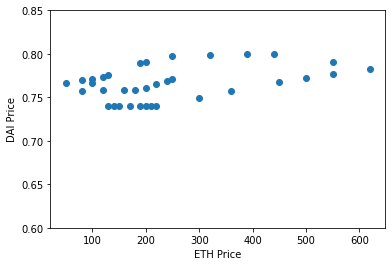

In [13]:
mp.scatter(eth_price, dai_price, marker='o')
mp.xlabel("ETH Price")
mp.ylabel("DAI Price")
mp.ylim(0.6,0.85)

tikzplotlib.save("price_hist_corr2.tex")
mp.show()

### Factorial Exp Analysis

r_s = 0.06
txf = 0.02

In [9]:
def get_filter_vars_from_path(path, filter_vars):
    path_split = path[12:-1].split(',')
        
    var_dict = {}
    
    for i in path_split:
        key, val = i.split(':')
        var_dict[key] = val 

    return [var_dict[filter_var] for filter_var in filter_vars]

def percentage_unset_bits(risk_bitmask):
    return round((risk_bitmask.count('0') / len(risk_bitmask)) * 100, 2)


In [12]:
experiment_dir = "Experiments/FactExp50Risk/logs"
plot_dir = "Experiments/FactExp50Risk/plots"

os.makedirs(plot_dir, exist_ok=True)

cdp_rate = 0.06 
txf = 0.02

filter_vars = ['mean_usd', 'mean_dai', 'stddev_dai', 'stddev_usd']

dai_var_list = [30, 64, 98, 132, 166]
usd_var_list = [30, 64, 98, 132, 166]

dai_var_list = [30, 166]
usd_var_list = [30, 166]

for dai_var in dai_var_list:
    for usd_var in usd_var_list:

        plot_dict_usd = defaultdict(list)
        plot_dict_dai = defaultdict(list)

        for logdir in os.listdir(experiment_dir):

            summary_file = os.path.join(experiment_dir, logdir, "sim-summary.pickle")

            infile = open(summary_file, 'rb')
            cdp_axis, txf_axis, run_axis, dai_price_history_axis, asset_history_axis, risk_params = pickle.load(infile)
            infile.close()

            dai_price = dai_price_history_axis[0]

            filtered_vars = get_filter_vars_from_path(logdir, filter_vars)

            if math.floor(float(filtered_vars[2])) == dai_var and math.floor(float(filtered_vars[3])) == usd_var:
                plot_dict_usd[float(filtered_vars[0])].append((dai_price, float(filtered_vars[1])))
                plot_dict_dai[float(filtered_vars[1])].append((dai_price, float(filtered_vars[0])))

        for plot_dict_key in sorted(plot_dict_usd.keys()):
            plot_dict_usd[plot_dict_key] = sorted(plot_dict_usd[plot_dict_key], key = lambda x : x[1])

            x = [i[1] for i in plot_dict_usd[plot_dict_key]]
            y = [i[0] for i in plot_dict_usd[plot_dict_key]]

            mp.ylabel("Settling DAI Price")
            mp.xlabel("Mean DAI")
            mp.title("Stddev USD: " + str(usd_var) + ", Stddev DAI: " + str(dai_var))
            mp.plot(x,y, marker='o', label="Mean USD: " + str(plot_dict_key))
        
        plot_title = "Stddev USD: " + str(usd_var) + ", Stddev DAI: " + str(dai_var) + "_mean_dai_on_x"
        
        mp.legend()
        mp.savefig(os.path.join(plot_dir, plot_title + ".jpeg"))
        tikzplotlib.save(os.path.join(plot_dir, plot_title + ".tex"))
        
        mp.clf()

        for plot_dict_key in sorted(plot_dict_usd.keys()):
            plot_dict_dai[plot_dict_key] = sorted(plot_dict_dai[plot_dict_key], key = lambda x : x[1])

            x = [i[1] for i in plot_dict_dai[plot_dict_key]]
            y = [i[0] for i in plot_dict_dai[plot_dict_key]]

            mp.ylabel("Settling DAI Price")
            mp.xlabel("Mean USD")
            mp.title("Stddev USD: " + str(usd_var) + ", Stddev DAI: " + str(dai_var))
            mp.plot(x,y, marker='o', label="Mean DAI: " + str(plot_dict_key))
        
        plot_title = "Stddev USD: " + str(usd_var) + ", Stddev DAI: " + str(dai_var) + "_mean_usd_on_x"

        mp.legend()
        mp.savefig(os.path.join(plot_dir, plot_title + ".jpeg"))
        tikzplotlib.save(os.path.join(plot_dir, plot_title + ".tex"))
        mp.clf()

<Figure size 432x288 with 0 Axes>

### DAI Settling Price v/s Risk Percentage
r_s = 0.02, txf = 0.02

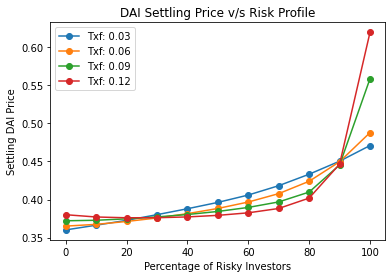

In [11]:
experiment_dir = "Experiments/RiskBitmaskExperimentHigh/logs"
plot_dir = "Experiments/RiskBitmaskExperimentHigh/plots"

os.makedirs(plot_dir, exist_ok=True)

cdp_rate = 0.02 
txf_list = [i * 0.03 for i in range(1, 5)]

filter_vars = ['mean_usd', 'mean_dai', 'stddev_dai', 'stddev_usd', 'risk_bitmask']

for txf in txf_list:
    plot_dict_risk = defaultdict(list)

    for logdir in os.listdir(experiment_dir):

        summary_file = os.path.join(experiment_dir, logdir, "sim-summary.pickle")

        infile = open(summary_file, 'rb')
        cdp_axis, txf_axis, run_axis, dai_price_history_axis, asset_history_axis, risk_params = pickle.load(infile)
        infile.close()

        filtered_vars = get_filter_vars_from_path(logdir, filter_vars)

        for cdp, txfee, daip in zip(cdp_axis, txf_axis, dai_price_history_axis):
            if txfee == txf:
                plot_dict_risk[float(percentage_unset_bits(filtered_vars[4]))].append(daip[0])

    for plot_dict_key in sorted(plot_dict_risk.keys()):
        plot_dict_risk[plot_dict_key] = sum(plot_dict_risk[plot_dict_key]) / len(plot_dict_risk[plot_dict_key])

    x = []
    y = []

    for plot_dict_key in sorted(plot_dict_risk.keys()):
        x.append(plot_dict_key)
        y.append(plot_dict_risk[plot_dict_key])

    mp.plot(x,y, marker='o', label = "Txf: " + str(txf)) 
    mp.xlabel("Percentage of Risky Investors")
    mp.ylabel("Settling DAI Price")

plot_name = "DAIPrice_vs_RiskPercentage_CDPRate_0.02"
mp.title("DAI Settling Price v/s Risk Profile")    
mp.legend()
mp.savefig(os.path.join(plot_dir, plot_name) + ".jpeg")
tikzplotlib.save(os.path.join(plot_dir, plot_title + ".tex"))
mp.show()